# Notes on azimuth calculation:

- The azimuth is equal to the current bearing:

azimuth = bearing(c(lon, lat), c(last_lon, last_lat))

This means forecast for next location depends on forecast for bearing

- Forecast for next point:
 destPoint(c(lon, lat), next_azimuth, estimated_ground_distance)

- For ground speed = 0 most frequent values of azimuth are: 180, 89, 271, 240, 120, 59, 301, 239, 58

In [1]:
library(plyr)
library(dplyr)
library(data.table)
library(splines)
library(parallel)
library(ggplot2)


Attaching package: 'dplyr'

The following objects are masked from 'package:plyr':

    arrange, count, desc, failwith, id, mutate, rename, summarise,
    summarize

The following objects are masked from 'package:stats':

    filter, lag

The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union


Attaching package: 'data.table'

The following objects are masked from 'package:dplyr':

    between, first, last

Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang


# User defined functions

In [2]:
get_azi_change_df <- function(ac_data) {
  ac_data[, "last_azimuth" := c(NA, azimuth[-.N]), by = "id"]
  azi_change_idx <- which(ac_data$azimuth != ac_data$last_azimuth | is.na(ac_data$last_azimuth))
  azi_change_idx <- unique(unlist(lapply(azi_change_idx, function(idx) c(idx - 1, idx))))
  azi_change_idx <- azi_change_idx[azi_change_idx != 0]
  azi_change_df <- ac_data[azi_change_idx, ]
  azi_change_df <- azi_change_df[azi_change_df$altitude != 0, ]
  azi_change_df <- azi_change_df[, c("id", "ts", "azimuth", "ts_readable"#, "climb_rate"#,
                                     #"est_climb_rate"
  )]
  return(azi_change_df)
}

get_azi_diff <- function(azimuths) {
  diffs <- diff(azimuths)
  diffs[diffs < (-180)] <- diffs[diffs < (-180)] + 360
  diffs[diffs > 180] <- diffs[diffs > 180] - 360
  return(diffs)
}

identify_bank_phase <- function(uniq_id, plot_turns = T, return_dataframe = T, plot_point = F) {
  return_df <- data.frame()
  for(id1 in uniq_id) {
    tryCatch({
      id1_df <- azi_change_df[azi_change_df$id == id1, ]
      est_bank_rate <- get_azi_diff(id1_df$azimuth)/diff(id1_df$ts)
      bank_rate_sign <- c(0, sign(est_bank_rate))
      bank_rate_sign_change <- c(F, bank_rate_sign[-1] != bank_rate_sign[-length(bank_rate_sign)])
      id1_df$bank_rate_sign <- bank_rate_sign
      id1_df$bank_rate_sign_change <- bank_rate_sign_change
      id1_df$last_ts_diff <- c(0, diff(id1_df$ts))
      id1_df$last_azimuth_diff <- c(0, get_azi_diff(id1_df$azimuth))
      # id1_df$est_bank_rate <- c(0, est_bank_rate)
      id1_df$total_bank_rate_sign_change <- cumsum(id1_df$bank_rate_sign_change)
      setDT(id1_df)
      # id1_df[, c("total_bank_angle", "total_time") := list(sum(last_azimuth_diff), sum(last_ts_diff)), by = total_bank_rate_sign_change]
      df1 <- id1_df[, .("ts_readable" = ts_readable[1], "total_bank_angle" = sum(last_azimuth_diff), "total_time" = sum(last_ts_diff)), by = "total_bank_rate_sign_change"]
      df1$avg_bank_rate <- df1$total_bank_angle/df1$total_time
      angle_correction_sum <- (df1$total_bank_angle + c(NA, df1$total_bank_angle[-nrow(df1)]))[-1]
      time_correction_sum <- (df1$total_time + c(NA, df1$total_time[-nrow(df1)]))[-1]
      df1$turn <- F
      df1$turn[(abs(df1$avg_bank_rate) > 0.5 & df1$total_time > 12) |
                 abs(df1$total_bank_angle) > 12
               ] <- T
      df1$turn[which(df1$turn) + 1] <- T
      df2 <- df1[df1$turn, ]
      correction_total_bank_angle <- df2$total_bank_angle[-1] + df2$total_bank_angle[-nrow(df2)]
      correction_total_time <- df2$total_time[-1] + df2$total_time[-nrow(df2)]
      idxs <- which(abs(correction_total_bank_angle) < 10 & correction_total_time < 60 &
                      (abs(df2$total_bank_angle[-1]) > 10 | abs(df2$total_bank_angle[-nrow(df2)]) > 10))
      if(length(idxs) > 0) {
        for(idx in idxs) {
          df1$turn[which(df1$turn)[idx:(idx + 1)]] <- F
        }
      }
      id1_df1 <- merge(id1_df, df1, all = T, by = c("total_bank_rate_sign_change", "ts_readable"))
      id1_df1$turn[is.na(id1_df1$turn)] <- F
      id1_df1$total_azi_change <- id1_df1$ts_readable <- NULL
      
      id1_df2 <- merge(id1_df1, ac_data[ac_data$id == id1], all = T, by = c("id", "ts", "azimuth"))
      id1_df2$turn[is.na(id1_df2$turn)] <- F
      turns_df <- id1_df2[id1_df2$turn, ]
      
      if(plot_turns) {
        if(!is.na(turns_df$jfk_landing_flag[1])) {
          png(paste0("bank/jfk_landing/", id1, ".png"), width = 800, height = 600)
        } else {
          png(paste0("bank/", id1, ".png"), width = 800, height = 600)
        }
        # plot(id1_df2$lon, id1_df2$lat)
        # points(id1_df2$lon[id1_df2$turn], id1_df2$lat[id1_df2$turn], pch = 20, col = "red")
        if(plot_point) {
          p <- ggplot() + geom_point(data = id1_df2, aes(x = lon, y = lat, colour = altitude)) +
            geom_point(data = turns_df, aes(x = lon, y = lat))
        } else {
          p <- ggplot() + geom_path(data = id1_df2, aes(x = lon, y = lat),
                                    arrow = arrow(type = "closed", angle = 18,
                                                  length = unit(0.05, "inches"))) +
            geom_point(data = turns_df, aes(x = lon, y = lat, colour = altitude)) +
            scale_colour_gradient(low = "red", high = "green")
        }
        print(p)
        dev.off()
      }
      if(return_dataframe) {
        return_df <- rbind(return_df, id1_df2)
      }
    }, error = function(e) print(e))
  }
  return(return_df)
}

In [3]:
dir.create("bank", showWarnings = F)
dir.create("bank/jfk_landing", showWarnings = F)
ac_data <- fread("../../../samples_with_jfk_landing_flag.csv")
ac_data <- ac_data[ac_data$ground_flag != 1, ]
setDT(ac_data)
setorder(ac_data, id, ts)
ac_data$ts_readable <- as.POSIXct.numeric(as.numeric(ac_data$ts), origin="1970-01-01")

In [4]:
azi_change_df <- get_azi_change_df(ac_data)
azi_change_df$azi_change <- TRUE
ac_data <- merge(ac_data, azi_change_df, all = T)
ac_data$azi_change[is.na(ac_data$azi_change)] <- F
ac_data[, "total_azi_change" := cumsum(azi_change), by = "id"]
ac_data[, "next_ts" := c(ts[-1], NA), by = "id"]
ac_data$next_ts_diff <- ac_data$next_ts - ac_data$ts
azi_change_df <- ac_data[ac_data$azi_change,
                         c("id", "ts", "ts_readable",
                           "azimuth", "total_azi_change"
                         )]
ac_data$azi_change <- NULL

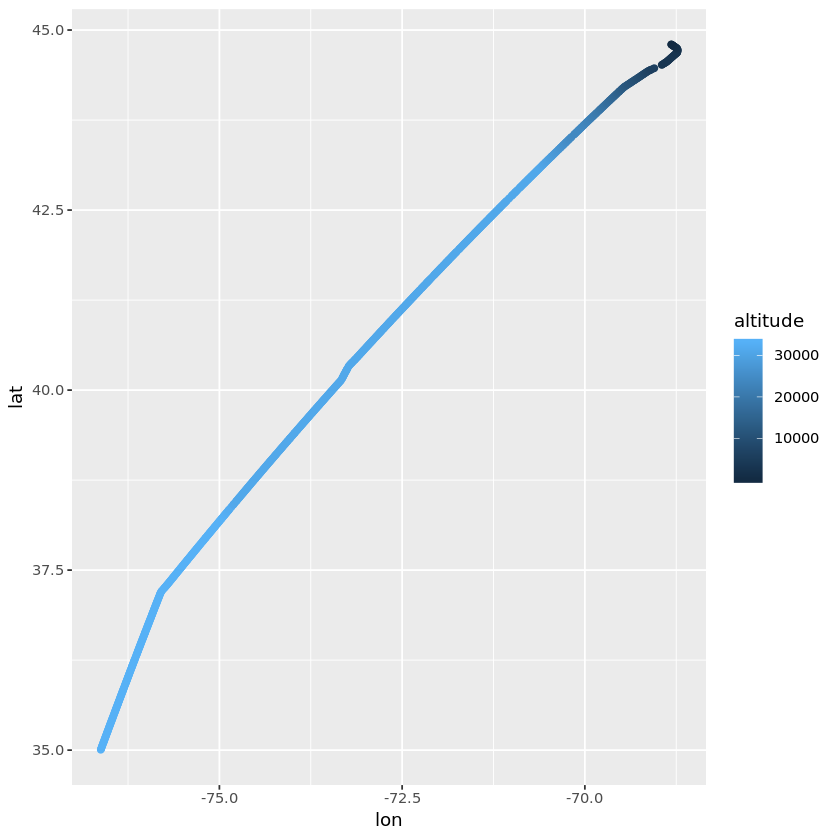

In [5]:
df <- ac_data[, .(nrows = .N, max_alt = max(altitude)), by = "id"]
df <- df[df$max_alt >= 30000]
id1 <- df$id[which.max(df$nrows)]
ggplot(ac_data[ac_data$id == id1]) + geom_point(aes(x = lon, y = lat, col = altitude))

In [6]:
uniq_id <- unique(ac_data$id)
cores <- detectCores() - 1
num <- ceiling(length(uniq_id)/cores)
idx <- ceiling(1:length(uniq_id)/num)
uniq_id_splits <- split(uniq_id, idx)

In [7]:
cl <- makeCluster(cores)
clusterExport(cl, list("azi_change_df", "ac_data", "tryCatch", "diff", "c", "sign", "cumsum",
                       "list", "sum", "merge", "is.na", "abs", "setDT", "get_azi_diff", "ggplot",
                       "geom_point", "aes", "geom_path", "arrow", "unit", "scale_colour_gradient"))
ret <- parLapply(cl = cl, X = uniq_id_splits, fun = identify_bank_phase)
ret <- do.call(rbind, ret)
ret$turn[ret$ground_speed == 0] <- F
ret$avg_bank_rate[!ret$turn] <- 0
stopCluster(cl)

[1] 0.9648188


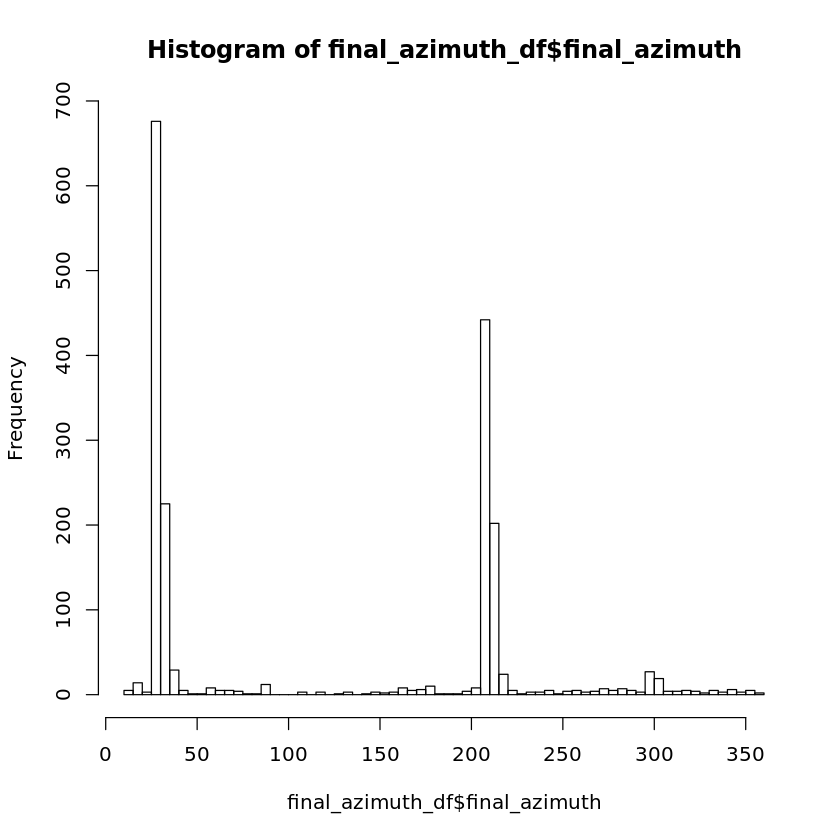

In [8]:
jfk_data <- ac_data[ac_data$jfk_landing_flag, ]
final_azimuth_df <- jfk_data[, .(final_azimuth = azimuth[.N],
                                 destination = destination[.N],
                                 max_altitude = max(altitude)), by = id]
print(mean(final_azimuth_df$destination == "JFK"))
hist(final_azimuth_df$final_azimuth, breaks = 80)

In [10]:
colnames(ret)

[1] "id"                          "ts"                         
 [3] "azimuth"                     "total_bank_rate_sign_change"
 [5] "bank_rate_sign"              "bank_rate_sign_change"      
 [7] "last_ts_diff"                "last_azimuth_diff"          
 [9] "total_bank_angle"            "total_time"                 
[11] "avg_bank_rate"               "turn"                       
[13] "ts_readable"                 "aircraft"                   
[15] "lat"                         "lon"                        
[17] "altitude"                    "climb_rate"                 
[19] "ground_speed"                "jfk_landing_flag"           
[21] "source"                      "destination"                
[23] "ground_flag"                 "last_azimuth"               
[25] "total_azi_change"            "next_ts"                    
[27] "next_ts_diff"

# Postprocessing turns

In [21]:
turn_idx <- which(ret$turn)
avg_bank_rate_df <- ret[ret$turn, c("id", "ts", "avg_bank_rate")]
avg_bank_rate_df[, "last_avg_bank_rate" := c(avg_bank_rate[1] - 1, avg_bank_rate[-.N]), by = "id"]
avg_bank_rate_df$avg_bank_rate_sign <- sign(avg_bank_rate_df$avg_bank_rate)
avg_bank_rate_df$last_avg_bank_rate_sign <- sign(avg_bank_rate_df$last_avg_bank_rate)
avg_bank_rate_df$avg_bank_rate_sign_change <- (avg_bank_rate_df$avg_bank_rate_sign != avg_bank_rate_df$last_avg_bank_rate_sign)

In [34]:
df <- avg_bank_rate_df[!avg_bank_rate_df$avg_bank_rate_sign_change, ]
head(df)

id,ts,avg_bank_rate,last_avg_bank_rate,avg_bank_rate_sign,last_avg_bank_rate_sign,avg_bank_rate_sign_change
001915_0,1559000150,0.0000000,0.0000000,0,0,FALSE
00308D_0,1558745990,-0.5098039,-1.5098039,-1,-1,FALSE
00308D_2,1558748256,-0.9480519,-1.9480519,-1,-1,FALSE
00308D_2,1558748608,0.5675676,0.1250000,1,1,FALSE
00B0EF_0,1558951159,-0.1657459,-1.1657459,-1,-1,FALSE
00B0EF_2,1558971448,1.4482759,0.4482759,1,1,FALSE


In [24]:
length(turn_idx)
nrow(avg_bank_rate_df)

[1] 517233

[1] 517233

In [28]:
remove_turn_idx <- turn_idx[!avg_bank_rate_df$avg_bank_rate_sign_change]
ret$turn[remove_turn_idx] <- F

# Checking by plotting examples

In [35]:
dir.create("removed", showWarnings = F)
for(id1 in unique(df$id)) {
    png(paste0("removed/", id1, ".png"))
    df1 <- df[df$id == id1, ]
    id1_df <- ac_data[ac_data$id == id1, ]
    plot(id1_df$lon, id1_df$lat)
    points(ret$lon[ret$turn & ret$id == id1],
           ret$lat[ret$turn & ret$id == id1],
          pch = 19, col = "blue")
    for(ts1 in df1$ts) {
        points(id1_df$lon[id1_df$ts == ts1],
               id1_df$lat[id1_df$ts == ts1],
              pch = 19, col = "red")
    }
    dev.off()
}

In [36]:
saveRDS(ret[, c("id", "ts", "azimuth", "turn", "avg_bank_rate")],
        "estimated_banking.Rds")
saveRDS(ret, "full_estimated_banking.Rds")

# Observations

- Landing azimuths ranges: 25-35 and 205-215
- Most frequent: 30, 201, 31, 211, 29, 300